In [1]:
import tarfile
import os
import shutil

# from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

inputDir = './data'
outputDir = '/processedData'

def ExtractFiles():
    # look for downloaded compressed & uncompressed tarfiles
    tarfilesList =  [ archive for archive in os.listdir(inputDir)
                    if archive[-4:] == '.tar' or archive[-7:] == '.tar.gz' 
                    ] # filter archives

    # remove possibly existing 'extracted'-Folder, else: pass
    try:
        shutil.rmtree(f"{inputDir}/extracted")
    except:
        pass

    # extract to 'extracted'-Folder
    for archive in tarfilesList:
        f = tarfile.open(f"{inputDir}/{archive}") # open tarfile
        f.extractall(f"{inputDir}/extracted/{archive[17:25]}_{archive[10:16]}") # extract to folder 'acquisitiondate_row+column'
        f.close

    return

#ExtractFiles()


def MakeFilelist():
    # look through extracted tarfile-Folders
    archivesList = [ archive for archive in os.listdir(f"{inputDir}/extracted") ]

    # nameList with paths to all TIF-files to read
    nameList = []

    for idx1, archive in enumerate(archivesList):
        #print(archive)
        nameList.append(list())

        # look through the bands of one Folder
        bandList = [ band for band in os.listdir(f"{inputDir}/extracted/{archive}") if band[-4:] == '.TIF']
        bandList.sort()
        for idx2, band in enumerate(bandList):
            nameList[idx1].append(f"{inputDir}/extracted/{archive}/{band}")
            #print(band)

    # sort folders from oldest to newest
    nameList.sort(reverse=False)

    # sort bands ascending
    for names in nameList:
        names.sort(key=len)

    return nameList

fileList = MakeFilelist()

fileList[0][0]


'./data/extracted/20200811_195023/LC08_L1TP_195023_20200811_20200918_02_T1_B1.TIF'

In [2]:
#import required libraries
import rasterio
from rasterio import plot
%matplotlib inline

#import bands as separate 1 band raster
band4 = rasterio.open(fileList[2][3]) #red
band5 = rasterio.open(fileList[2][4]) #nir

#number of raster rows
band4.height


8051

In [3]:

#number of raster columns
band4.width


7961

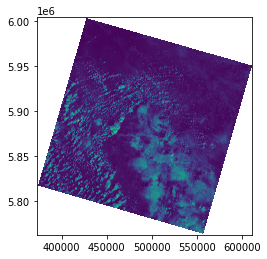

<AxesSubplot:>

In [4]:

#plot band 
plot.show(band4)


In [5]:

#type of raster byte
band4.dtypes[0]


'uint16'

In [6]:

#raster sytem of reference
band4.crs


CRS.from_epsg(32632)

In [7]:

#raster transform parameters
band4.transform


Affine(30.0, 0.0, 371985.0,
       0.0, -30.0, 6003915.0)

In [8]:

#raster values as matrix array
band4.read(1)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

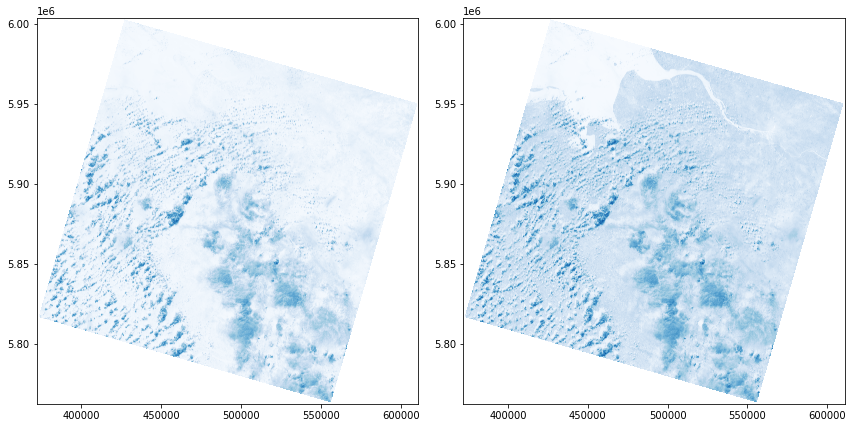

In [9]:

#multiple band representation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot.show(band4, ax=ax1, cmap='Blues') #red
plot.show(band5, ax=ax2, cmap='Blues') #nir
fig.tight_layout()


In [10]:

#generate nir and red objects as arrays in float64 format
red = band4.read(1).astype('float64')
nir = band5.read(1).astype('float64')

nir

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:

#ndvi calculation, empty cells or nodata cells are reported as 0
ndviArr=np.where(
    (nir+red)==0., 
    0, 
    (nir-red)/(nir+red))
ndviArr[:5,:5]

C:\Users\Admin\AppData\Local\Temp/ipykernel_13492/2466996422.py:5: RuntimeWarning: invalid value encountered in true_divide
  (nir-red)/(nir+red))


array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [33]:
try:
    os.mkdir('data/output')
except:
    shutil.rmtree('data/output')
    os.mkdir('data/output')
    pass

In [34]:
#export ndvi image
with rasterio.open('data/output/ndviImage.tiff',
                    'w',
                    driver='Gtiff',
                    width=band4.width,
                    height = band4.height,
                    count=1, crs=band4.crs,
                    transform=band4.transform,
                    dtype='float64') as ndviImage:
                    
    ndviImage.write(ndviArr, 1)



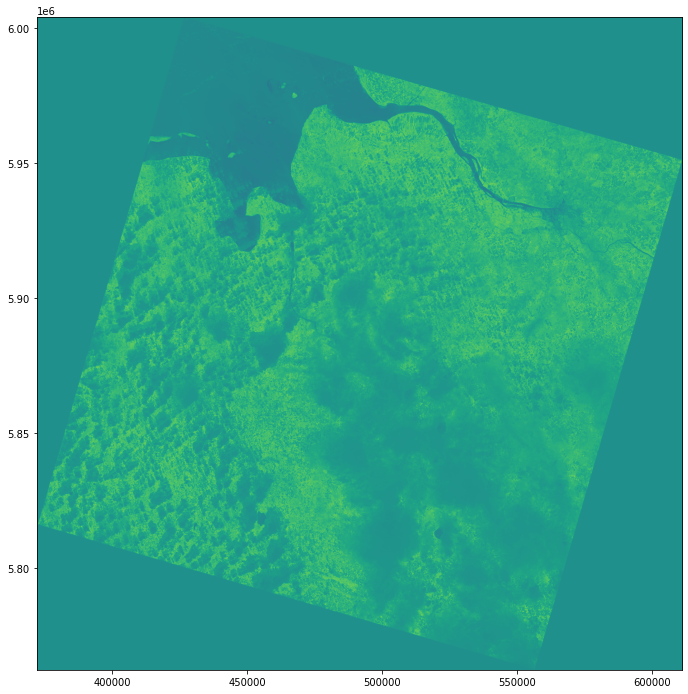

In [36]:

#plot ndvi
with rasterio.open('data/output/ndviImage.tiff') as ndvi:
    fig = plt.figure(figsize=(18,12))
    plot.show(ndvi)

In [ ]:

def open_clean_bands(band_path):
    """A function that opens a Landsat band as an (rio)xarray object

    Parameters
    ----------
    band_path : list
        A list of paths to the tif files that you wish to combine.
        
    Returns
    -------
    An single xarray object with the Landsat band data.

    """
     
    return rxr.open_rasterio(band_path, masked=True).squeeze()

In [13]:
all_scenes = []

# open all scenes in a loop
for scene in fileList:
    all_bands = []

    # Open all bands in a loop
    for i, band in enumerate(scene):
        all_bands.append(open_clean_bands(band))
        # Assign a band number to the new xarray object
        all_bands[i]["band"]=i+1

    all_scenes.append(all_bands)

all_scenes[0][0]

<xarray.DataArray (y: 8041, x: 7961)>
[64014401 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 4.14e+05 4.14e+05 4.141e+05 ... 6.528e+05 6.528e+05
  * y            (y) float64 6.16e+06 6.16e+06 6.16e+06 ... 5.919e+06 5.919e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [14]:
ndvi = []

# calculate indices of the bands: (red-nir)/(red+nir)
for scene in all_scenes:
    ndvi.append((scene[3] - scene[4]) / (scene[3] + scene[4]))

ndvi

[<xarray.DataArray (y: 8041, x: 7961)>
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
 Coordinates:
   * x            (x) float64 4.14e+05 4.14e+05 4.141e+05 ... 6.528e+05 6.528e+05
   * y            (y) float64 6.16e+06 6.16e+06 6.16e+06 ... 5.919e+06 5.919e+06
     spatial_ref  int64 0,
 <xarray.DataArray (y: 7971, x: 7861)>
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
 Coordinates:
   * x            (x) float64 4.773e+05 4.773e+05 ... 7.131e+05 7.131e+05
   * y            (y) float64 6.

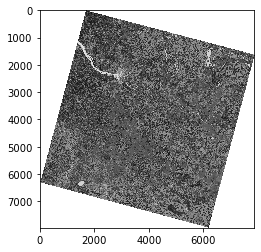

In [16]:
plt.imshow(ndvi[1][:], cmap='gray')

plt.show()

In [18]:
fileList[1]

['./data/extracted/20200811_195023/LC08_L1TP_195023_20200811_20200918_02_T1_B1.TIF',
 './data/extracted/20200811_195023/LC08_L1TP_195023_20200811_20200918_02_T1_B2.TIF',
 './data/extracted/20200811_195023/LC08_L1TP_195023_20200811_20200918_02_T1_B3.TIF',
 './data/extracted/20200811_195023/LC08_L1TP_195023_20200811_20200918_02_T1_B4.TIF',
 './data/extracted/20200811_195023/LC08_L1TP_195023_20200811_20200918_02_T1_B5.TIF',
 './data/extracted/20200811_195023/LC08_L1TP_195023_20200811_20200918_02_T1_B6.TIF',
 './data/extracted/20200811_195023/LC08_L1TP_195023_20200811_20200918_02_T1_B7.TIF',
 './data/extracted/20200811_195023/LC08_L1TP_195023_20200811_20200918_02_T1_B8.TIF',
 './data/extracted/20200811_195023/LC08_L1TP_195023_20200811_20200918_02_T1_B9.TIF',
 './data/extracted/20200811_195023/LC08_L1TP_195023_20200811_20200918_02_T1_B10.TIF',
 './data/extracted/20200811_195023/LC08_L1TP_195023_20200811_20200918_02_T1_B11.TIF',
 './data/extracted/20200811_195023/LC08_L1TP_195023_20200811_20

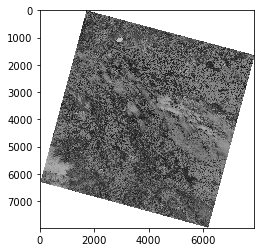

In [17]:
# OPTIONAL: Turn list of bands into a single xarray object --> only for Indices!
# red = band 4, near infrared = band 5
# NDVI = NIR-RED / NIR + RED

# NDVI= xr.concat(all_bands, dim="band") 


In [11]:
all_bands

[<xarray.DataArray (y: 7971, x: 7861)>
 [62660031 values with dtype=float32]
 Coordinates:
     band         int64 1
   * x            (x) float64 4.773e+05 4.773e+05 ... 7.131e+05 7.131e+05
   * y            (y) float64 6.004e+06 6.004e+06 ... 5.765e+06 5.764e+06
     spatial_ref  int64 0
 Attributes:
     scale_factor:  1.0
     add_offset:    0.0,
 <xarray.DataArray (y: 7971, x: 7861)>
 [62660031 values with dtype=float32]
 Coordinates:
     band         int64 2
   * x            (x) float64 4.773e+05 4.773e+05 ... 7.131e+05 7.131e+05
   * y            (y) float64 6.004e+06 6.004e+06 ... 5.765e+06 5.764e+06
     spatial_ref  int64 0
 Attributes:
     scale_factor:  1.0
     add_offset:    0.0,
 <xarray.DataArray (y: 7971, x: 7861)>
 [62660031 values with dtype=float32]
 Coordinates:
     band         int64 3
   * x            (x) float64 4.773e+05 4.773e+05 ... 7.131e+05 7.131e+05
   * y            (y) float64 6.004e+06 6.004e+06 ... 5.765e+06 5.764e+06
     spatial_ref  int64 0
 At

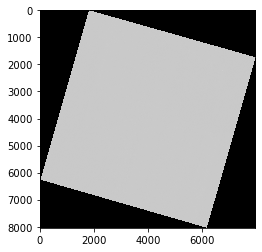

In [87]:
import rasterio
from skimage import io
from matplotlib import pyplot as plt



with rasterio.open(nameList[0][8]) as ds:
    arr = ds.read()  # read all raster values

plt.imshow(arr[0,:,:], cmap='gray')

plt.show()

In [ ]:
timeline = []

for name in nameList:




with rasterio.open(nameList[0][0]) as ds:
    arr = ds.read()  # read all raster values

plt.imshow(arr[0,:,:], cmap='gray')

plt.show()

In [34]:
from osgeo import gdal

dataset = gdal.Open(nameList[0][0], gdal.GA_ReadOnly)

# How many bands does this image have?
num_bands = dataset.RasterCount
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows = dataset.RasterYSize
cols = dataset.RasterXSize
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# Does the raster have a description or metadata?
desc = dataset.GetDescription()
metadata = dataset.GetMetadata()

print('Raster description: {desc}'.format(desc=desc))
print('Raster metadata:')
print(metadata)
print('\n')

# What driver was used to open the raster?
driver = dataset.GetDriver()
print('Raster driver: {d}\n'.format(d=driver.ShortName))

# What is the raster's projection?
proj = dataset.GetProjection()
print('Image projection:')
print(proj + '\n')

# What is the raster's "geo-transform"
gt = dataset.GetGeoTransform()
print('Image geo-transform: {gt}\n'.format(gt=gt))


Number of bands in image: 1

Image size is: 7961 rows x 7861 columns

Raster description: ./data/extracted/LC08_L1TP_195023_20170328_20170414_01_T1/LC08_L1TP_195023_20170328_20170414_01_T1_B1.TIF
Raster metadata:
{'AREA_OR_POINT': 'Point'}


Raster driver: GTiff

Image projection:
PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32632"]]

Image geo-transform: (473385.0, 30.0, 0.0, 6003315.0, 0.0, -30.0)



In [38]:
import earthpy.spatial as es
import earthpy.plot as ep
import matplotlib.pyplot as plt

array_stack, meta_data = es.stack(nameList[0], nodata=-9999)

titles = ["Ultra Blue", "Blue", "Green", "Red", "NIR", "SWIR 1", "SWIR 2", "SWIR 23", "SWIR 24", "SWIR 2344", "SWIR 234444", "SWIR 243"]
# sphinx_gallery_thumbnail_number = 1
ep.plot_bands(array_stack, title=titles)
plt.show()

ValueError: Please ensure all source rasters have same affine transform.

In [87]:
from skimage import io
import numpy as np
from IPython.core.display import display
import matplotlib.pyplot as plt

LC08_L1TP_195023_20170328_20170414_01_T1
LC08_L1TP_196023_20170215_20170228_01_T1


In [80]:
import os
from glob import glob

import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# walk() durch die entpackte Szene, filtern nach '.TIF'
files = os.walk(inputDir)

for f in files:
        # print(f[0]) #dirpath
        # print(f[1]) #dirnames
        # print(f[2]) #filenames --> liste
        print(f"Directory '{f[0]}':\nFolders: {f[1]}\nFiles: {f[2]}")

        f_list = f[2]
        for f_name in f_list:
                if f_name[-4:] == '.TIF':
                        print(f_name)
                        bild = io.imread(f"{inputDir}/{f_name}")
                        plt.imshow(bild, cmap='gray')

Directory './data':
Folders: ['LC08_L1TP_195023_20170328_20170414_01_T1', 'LC08_L1TP_196023_20170215_20170228_01_T1']
Files: ['LC08_L1TP_195023_20170328_20170414_01_T1.tar.gz', 'LC08_L1TP_196023_20170215_20170228_01_T1.tar.gz']
Directory './data\LC08_L1TP_195023_20170328_20170414_01_T1':
Folders: []
Files: ['LC08_L1TP_195023_20170328_20170414_01_T1_ANG.txt', 'LC08_L1TP_195023_20170328_20170414_01_T1_B1.TIF', 'LC08_L1TP_195023_20170328_20170414_01_T1_B10.TIF', 'LC08_L1TP_195023_20170328_20170414_01_T1_B11.TIF', 'LC08_L1TP_195023_20170328_20170414_01_T1_B2.TIF', 'LC08_L1TP_195023_20170328_20170414_01_T1_B3.TIF', 'LC08_L1TP_195023_20170328_20170414_01_T1_B4.TIF', 'LC08_L1TP_195023_20170328_20170414_01_T1_B5.TIF', 'LC08_L1TP_195023_20170328_20170414_01_T1_B6.TIF', 'LC08_L1TP_195023_20170328_20170414_01_T1_B7.TIF', 'LC08_L1TP_195023_20170328_20170414_01_T1_B8.TIF', 'LC08_L1TP_195023_20170328_20170414_01_T1_B9.TIF', 'LC08_L1TP_195023_20170328_20170414_01_T1_BQA.TIF', 'LC08_L1TP_195023_201703

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\Coding\\AA_Projects\\gis-programmierung\\Testing\\data\\LC08_L1TP_195023_20170328_20170414_01_T1_B1.TIF'

In [17]:
print(os.getcwd())

os.chdir(inputDir)

print(os.getcwd())

os.chdir('../')

print(os.getcwd())

e:\Coding\AA_Projects\gis-programmierung\Testing
e:\Coding\AA_Projects\gis-programmierung\Testing\data
e:\Coding\AA_Projects\gis-programmierung\Testing


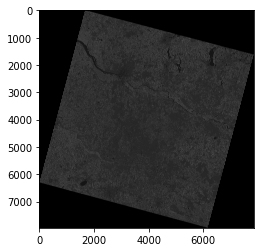

In [7]:
bandList = [ band for band in os.listdir(inputDir) if band[-4:] == '.TIF']
bild = io.imread(f"{inputDir}/{bandList[6]}")
type(bild)
plt.imshow(bild, cmap='gray')